<p><img style="float:right; margin:0px; padding:20px; max-height:50px" src="https://upload.wikimedia.org/wikipedia/commons/1/1a/Logo_uab.png"></p>
<p style="text-align:justify;">

LARA CASTILLEJO ROIG, 1641027

JÚLIA LIPIN GENER REY, 1667764

<hr/>
<h1 style="font-family: 'Arial'; font-weight: bold;">APRENENTATGE COMPUTACIONAL | UAB</h1>

<h2 style="font-family: 'Arial'; font-weight: bold;">CAS KAGGLE. SPOTIFY SONG ATTRIBUTES.</h2>

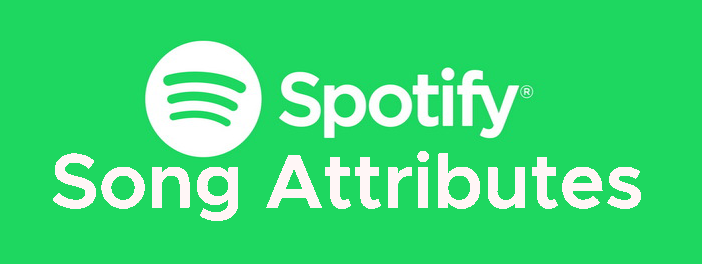


# 0. Introducció
<hr/>

<section>
<p style="font-family: 'Arial'; font-size:16px;"> Durant aquest projecte hem escollir el cas Kaggle <a href="https://www.kaggle.com/datasets/geomack/spotifyclassification">Spotify Song Attributes</a>, del qual analitzarem les dades que comporta i comentarem els resultats obtinguts.</p>

<p style="font-family: 'Arial'; font-size:16px;">Aquest conjunt de dades inclou 2017 cançons obtingudes de l'API de Spotify, i conté metadades sobre aquestes cançons, incloent diverses característiques musicals com la <span style="font-style:italic; font-family: 'Arial'; font-size:16px;">danceability, acousticness, energy,</span> entre d'altres. A més, cada cançó té assignada una etiqueta ("target"), indicant si l'usuari li ha donat like a aquesta cançó o no.</p>

<p style="font-family: 'Arial'; font-size:16px;">D'aquesta manera el nostre objectiu principal serà explorar les dades per comprendre les característiques musicals de cada cançó i utilitzar aquesta informació per construir un model de classificació. Finalment, aquest model predirà si una cançó serà del gust de l'usuari en funció de les seves característiques musicals.</p>
</section>

In [152]:
import pandas as pd
import numpy as np
import statistics
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 1. EDA | Exploratory Data Analysis
<hr/>

<section>
<p style="font-family: 'Arial'; font-size:16px;"> D'aquesta manera, el primer que farem serà un anàlisi exploratori per a comprendre les dades, les seves relacions i les diferents distribució amb les que treballarem.</p>
</section>

In [153]:
df = pd.read_csv("database/data.csv")
df = df.drop("Unnamed: 0", axis="columns")

num_files = df.shape[0]
num_columns = df.shape[1]
print("files:",num_files)
print("columnes:",num_columns)
display(df.head())
display(Markdown(f"""
<section><p style="font-family: 'Arial'; font-size:16px;"><br/>Ens trobem amb que, a la nostra base de dades, tenim {num_files} cançons i {num_columns} atributs, considerant que hem tret la columna 'Unnamed: 0' que és el número de fila.</p>
</section>"""))

files: 2017
columnes: 16


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys



<section><p style="font-family: 'Arial'; font-size:16px;"><br/>Ens trobem amb que, a la nostra base de dades, tenim 2017 cançons i 16 atributs, considerant que hem tret la columna 'Unnamed: 0' que és el número de fila.</p>
</section>

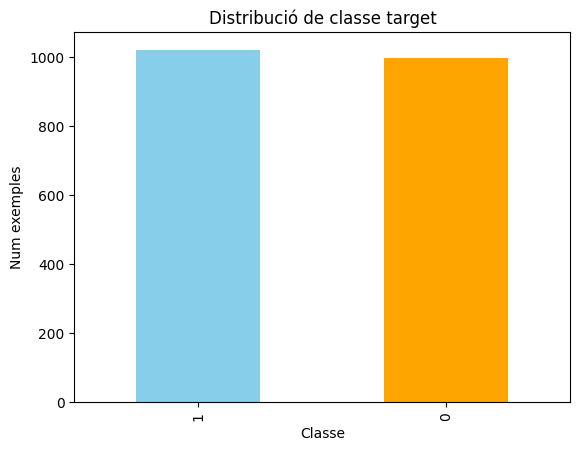

In [154]:
counts = df['target'].value_counts()

counts.plot(kind='bar', color=['skyblue', 'orange'])

plt.title('Distribució de classe target')
plt.xlabel('Classe')
plt.ylabel('Num exemples')

plt.show()

<section>
<p style="font-family: 'Arial'; font-size:16px;">Continuant analitzant la nostra base de dades podem observar amb la gràfica de barres que hem generat que la quantitat de mostres per a cada classe és similar, amb un percentatge aproximat del 50% per a cada una.</p>
    
<p style="font-family: 'Arial'; font-size:16px;">Aquesta distribució equilibrada ens implica que no hi ha un biaix entre les classes, i, per tant, no serà necessari que hàgim d'aplicar tècniques de sobremostratge o submostreig per ajustar les proporcions de les classes. Això és important, ja que ens facilitarà més l'entrenament del model de classificació que triem, ja que no s'haurà de compensar per sobre o sobrerepresentació d'una classe en particular.</p>
</section>

<section>
<p style="font-family: 'Arial'; font-size:16px;">Altrament, si anem a treballar en aquest dataset seria interessant profunditzar una mica més i veure de què tracten cada un dels atributs que formen aquesta.</p>
<ul style="font-family: 'Arial'; font-size:16px;">
    <li>Acousticness: Mesura l'acústica de la cançó.</li>
    <li>Danceability: Mesura de la facilitat amb la qual es pot ballar la cançó.</li>
    <li>Duration_ms: Duració de la cançó en mil·lisegons.</li>
    <li>Energy: Mesura de l'energia de la cançó, basada en la intensitat i la dinàmica del so.</li>
    <li>Instrumentalness: Mesura de la quantitat d'instrumentalització en la cançó (com més alt, menys instrument vocal hi ha)</li>
    <li>Key: Tó de la cançó.</li>
    <li>Liveness: Mesura que indica la probabilitat que la cançó hagi estat enregistrada en un estudi o en viu.</li>
    <li>Loudness: Mesura del volum de la cançó en decibels.</li>
    <li>Mode: Manera en què es percep la cançó (alegre, melancòlica...)</li>
    <li>Speechiness: Mesura de la quantitat de parla en la cançó. </li>
    <li>Tempo: Velocitat de la cançó en batuts per minut.</li>
    <li>Time_signature: Mesura de la signatura de temps, és a dir, com s'organitza el ritme de la música al llarg del temps. </li>
    <li>Valence: Mesura de l'estat d'ànim de la cançó.</li>
    <li>Target: Valor que indica si a l'usuari li ha agradat la cançó. </li>
    <li>Song_title: Nom de la cançó.</li>
    <li>Artist: Interpretant de la cançó.</li>
</ul>
</section>

<section>
<p style="font-family: 'Arial'; font-size:16px;">Ara que ja sabem de què tracta cada atribut, seria interessant veure també quin tipus de variable són i sí algun d'ells conte NaNs, ja que fer això ens ajudarà a l'hora de fer preprocessing.</p>
</section>

In [155]:
tipus_dades = df.dtypes

tipus = pd.DataFrame({
    'Atribut': tipus_dades.index,
    'Tipus de Dades': tipus_dades.values,
    'NaN': df.isna().sum().values,
    'Elements diferents': df.nunique().values
})
print(df['target'].value_counts(normalize=True))
tipus

target
1    0.505702
0    0.494298
Name: proportion, dtype: float64


,Atribut,Tipus de Dades,NaN,Elements diferents
0,acousticness,float64,0,1394
1,danceability,float64,0,632
2,duration_ms,int64,0,1921
3,energy,float64,0,719
4,instrumentalness,float64,0,1107
5,key,int64,0,12
6,liveness,float64,0,793
7,loudness,float64,0,1808
8,mode,int64,0,2
9,speechiness,float64,0,792


<section>
<p style="font-family: 'Arial'; font-size:16px;">Observant la taula obtinguda podem adonar-nos que tots els atributs són numèrics excepte song_title i artist, fet que des del principi ja se sospitava que fos així. També podem mencionar que mode i target són binaris.</p>

<p style="font-family: 'Arial'; font-size:16px;">Per altra banda, podem observar que no hi ha cap NaN a tota la base de dades, fet que ens facilitarà la feina en el preprocessament, ja que no caldrà gestionar valors nuls i podrem tenir un flux de treball més directe.</p>

<p style="font-family: 'Arial'; font-size:16px;">D'aquesta manera el que farem ara serà mira les correlacions entre els atributs i el target. Cal mencionar que, de primeres, l'atribut song_title no s'ha considerat en l'anàlisi de correlacions perquè hem pensat que no té una relació massa significativa amb les altres variables numèriques del dataset. El nom de la cançó és una variable categòrica textual que, per si sola, no aporta informació rellevant per identificar patrons o tendències en les altres característiques de la música, ja que molts cops hi ha cançons que es diuen igual o molt semblants i ser completament oposat respecte ritme, tons, etc.</p>

<p style="font-family: 'Arial'; font-size:16px;">D'altra banda, tot i que l'atribut artist també és una variable categòrica, l'hem modificat, ja que molts usuaris es basen en els seus artistes preferits per seleccionar música. Aquesta variable pot tenir influència en la predicció de si una persona li agradarà una cançó o no, ja que el nombre de likes que té posat en cançons d'aquell artista poden reflectir tendències en els gustos musicals.
En cas que el dataset fos una playlist també podrien mirar quantes cançons d'aquell artista té l'usuari. Però, tenint en compte que el cas Kaggle Spotify Song Attributs no s'està basant en una playlist sinó en una llista aleatòria de cançons, no ens basarem només la freqüència en que surt l'artista en el dataset sinó també tenint en compte que la canço li agradi a l'usuari.</p>

<p style="font-family: 'Arial'; font-size:16px;">Així doncs, afegirem l'atribut artist_likes en canvi d'artist, per a mirar quantes cançons d'un artista li ha donat like l'usuari.</p>
</section>

In [156]:
correl=df.copy()

artist_likes = correl[correl['target'] == 1].groupby('artist').size()
correl['artist_likes'] = correl['artist'].map(artist_likes).fillna(0)
correl = correl.drop(['song_title', 'artist'], axis=1)
correl = correl.reset_index(drop=True)

correl

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,artist_likes
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,6.0
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,2.0
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,6.0
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,6.0
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,0.0
2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,0.0
2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,0.0
2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,0.0


<section>
<p style="font-family: 'Arial'; font-size:16px;">Ara que ja tenim el nou atribut artist_likes al nostre dataset, i hem tret els atributs categòrics song_title i artist, podrem fer la matriu de correlacions.</p>
</section>

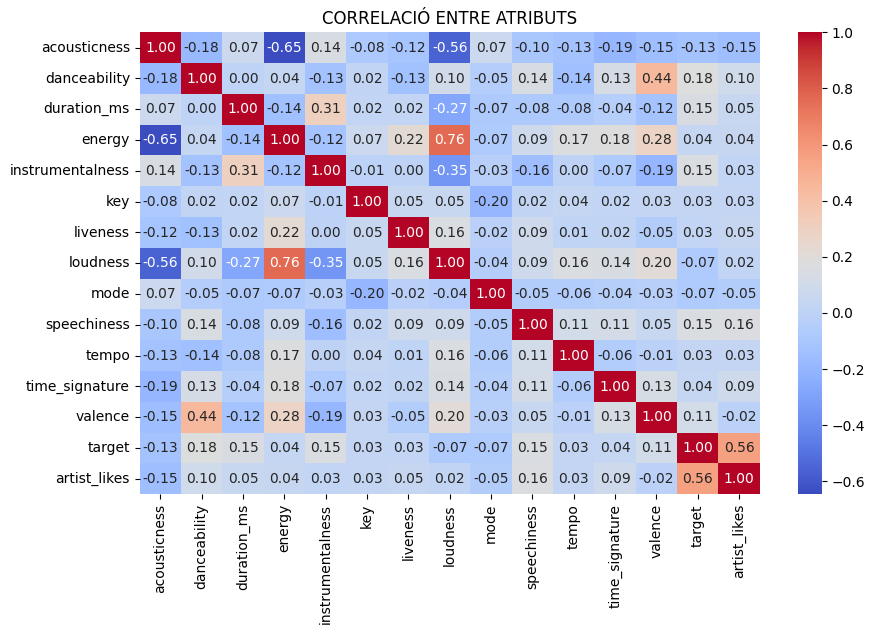

In [157]:
matriu_correlacions = correl.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(matriu_correlacions, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('CORRELACIÓ ENTRE ATRIBUTS')
plt.show()

<section>
<p style="font-family: 'Arial'; font-size:16px;">Les correlacions que podem destacar més es troben entre energy i loudness, ja que una cançó enèrgica tendeix a tenir una mesura alta de decibels, així com entre danceability i valance, on l'estat d'anim va lligat amb si la cançó es pot ballar o no. Aquestes relacions poden ser útils per predir les preferències musicals de l'usuari.</p>
    
<p style="font-family: 'Arial'; font-size:16px;">En relació amb la variable target, la danceability sembla influir lleugerament en si una cançó agrada o no, tot i que la correlació no és molt forta. Això suggereix que altres factors emocionals o relacionats amb l'artista podrien tenir un paper més important.</p>

<p style="font-family: 'Arial'; font-size:16px;">Podem observar que l'atribut nou que hem creat a partir de artist, artist_likes, es la que més es relaciona amb el target, com ja sospitavem des del principi, ja que un artista sol fer cançons d'un estil determinat, per tant la probabilitat de que t'agradi una cançó d'un artista que, pel general t'agraden les seves cançons, augmenta.</p>

</section>

# 2. Preprocessing
<hr/>

<section>
<p style="font-family: 'Arial'; font-size:16px;">Abans de passar les dades als models, dividirem el conjunt de dades en entrenament i prova per evitar data leakage i assegurar-nos que les dades de prova no influenixen en el procés d'entrenament. Un cop dividides les dades, aplicarem el preprocesament de manera separada al conjunt d'entrenament i al conjunt de test, utilitzant les "estadístiques" obtingudes en el train per evitar la contaminació de les dades de prova.</p>

<p style="font-family: 'Arial'; font-size:16px;">A més, modificarem la columna artist per afegir una nova característica que reflecteixi els "likes" obtinguts per cada artista en el conjunt d'entrenament, i després mapegem aquesta informació al conjunt de prova, tal i com s'ha mencionat a l'apartat d'Exploratory Data Analysis.</p>
</section>

In [158]:
def afegir_artist_likes(df):
    t=df.drop('song_title',axis=1)
    X = t.drop('target', axis=1)
    y = t['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train['target']=y_train
    artist_likes = X_train[X_train['target'] == 1].groupby('artist').size()
    X_train['artist_likes'] = X_train['artist'].map(artist_likes).fillna(0)
    X_train=X_train.drop('artist', axis=1)
    X_train=X_train.drop('target',axis=1)
    X_train = X_train.reset_index(drop=True)
    y_train= y_train.reset_index(drop=True)
    
    X_test['artist_likes'] = X_test['artist'].map(artist_likes).fillna(0)
    X_test= X_test.drop('artist', axis=1)
    X_test = X_test.reset_index(drop=True)
    y_test= y_test.reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

In [159]:
X_train, X_test, y_train, y_test= afegir_artist_likes(df)
X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_likes
0,0.34400,0.690,237040,0.737,0.000000,1,0.2430,-4.123,1,0.0363,115.020,4.0,0.821,2.0
1,0.01650,0.443,223800,0.804,0.000003,10,0.1810,-6.432,1,0.0406,151.928,4.0,0.437,0.0
2,0.05990,0.756,257053,0.853,0.000562,9,0.1150,-5.920,0,0.0525,100.004,4.0,0.426,2.0
3,0.00814,0.401,93267,0.972,0.878000,0,0.3820,-2.236,1,0.0886,152.839,4.0,0.405,9.0
4,0.80300,0.612,245493,0.570,0.000033,1,0.1220,-9.620,0,0.0735,169.842,4.0,0.813,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,0.10400,0.475,219280,0.920,0.000000,5,0.5750,-4.991,1,0.0941,154.906,4.0,0.729,0.0
1609,0.27000,0.446,259765,0.890,0.661000,7,0.4510,-7.974,1,0.0308,170.002,4.0,0.503,1.0
1610,0.08290,0.722,192026,0.619,0.000000,9,0.0533,-8.324,0,0.3520,140.031,4.0,0.606,2.0
1611,0.00120,0.605,200787,0.920,0.000596,4,0.4830,-2.298,0,0.0713,174.974,4.0,0.220,0.0


<section>
<p style="font-family: 'Arial'; font-size:16px;">Ara que ja tenim dividit les dades en train i test, haurem de processar les dades per poder tractar-les y avaluar-les més tard amb les mètriques adients.</p>

<p style="font-family: 'Arial'; font-size:16px;">Per començar, normalitzarem les dades per tal que no hi hagi problemes alhora d'avaluar el rendiment del nostre dataset, a causa de la falta de proporció entre diferents atributs. Per fer-ho, utilitzarem la funció StandardScaler per estandarditzar els atributs, restant la mitjana i dividint entre la desviació estàndard.En el cas de mode i time_signature ho omitirem ja que estan dins d'una escala que no cal.</p>
</section>

In [160]:
def normalitzar(X_train, X_test):
    nom_atributs = X_train.columns.tolist()

    columnes_no_normalitzar = ['mode', 'time_signature']

    columnes_a_normalitzar = [col for col in nom_atributs if col not in columnes_no_normalitzar]

    normalitzador = StandardScaler()

    X_train_normalizado = pd.DataFrame(normalitzador.fit_transform(X_train[columnes_a_normalitzar]), columns=columnes_a_normalitzar, index=X_train.index)
    X_test_normalizado = pd.DataFrame(normalitzador.transform(X_test[columnes_a_normalitzar]), columns=columnes_a_normalitzar, index=X_test.index)

    X_train = pd.concat([X_train_normalizado, X_train[columnes_no_normalitzar]], axis=1)
    X_test = pd.concat([X_test_normalizado, X_test[columnes_no_normalitzar]], axis=1)
    return X_train, X_test

In [161]:
X_train,X_test= normalitzar(X_train, X_test)
X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,artist_likes,mode,time_signature
0,0.619824,0.469817,-0.120653,0.247762,-0.491955,-1.194530,0.307275,0.779421,-0.622619,-0.262947,1.329405,0.416977,1,4.0
1,-0.649705,-1.052629,-0.283380,0.569259,-0.491944,1.285944,-0.087351,0.162161,-0.574509,1.126709,-0.218302,-0.665218,1,4.0
2,-0.481468,0.876624,0.125319,0.804384,-0.489900,1.010336,-0.507437,0.299033,-0.441365,-0.828328,-0.262638,0.416977,0,4.0
3,-0.682112,-1.311506,-1.887706,1.375401,2.717479,-1.470138,1.192002,1.283868,-0.037458,1.161010,-0.347278,4.204662,1,4.0
4,2.399101,-0.010956,-0.016760,-0.553582,-0.491834,-1.194530,-0.462882,-0.690079,-0.206405,1.801205,1.297161,-0.665218,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,-0.310518,-0.855389,-0.338933,1.125881,-0.491955,-0.092097,2.420436,0.547381,0.024079,1.238837,0.958600,-0.665218,1,4.0
1609,0.332968,-1.034138,0.158651,0.981927,1.924259,0.459119,1.631183,-0.250058,-0.684156,1.807230,0.047710,-0.124120,1,4.0
1610,-0.392310,0.667056,-0.673901,-0.318457,-0.491955,1.010336,-0.900154,-0.343622,2.909609,0.678765,0.462850,0.416977,0,4.0
1611,-0.709014,-0.054102,-0.566223,1.125881,-0.489776,-0.367705,1.834861,1.267294,-0.231020,1.994435,-1.092918,-0.665218,0,4.0


<section>
<p style="font-family: 'Arial'; font-size:16px;">Ara que ja hem estandarditzat les dades, separarem per quartils, tant el train com el test, per simplificar l'avaluació del model més tard. Per això, utilitzarem la funció qcut de la llibreria Pandas per dividir els valors dels diferents atributs del nostre dataset, especificant en quants quartils els volem dividir.
</p>
</section>

In [162]:
def agrupar(X_train, X_test):
    columnes_excloure = ['mode', 'time_signature']

    variables_continues = X_train.columns.tolist()
    bins_dict={}
    for var in variables_continues:
        if var not in columnes_excloure:
            if X_train[var].nunique() > 1:
                X_train[var], bins = pd.qcut(X_train[var], q=4, labels=False, duplicates='drop', retbins=True)
                bins_dict[var]=bins
                X_test[var] = pd.cut(X_test[var], bins=bins, labels=False, include_lowest=True)
    
    X_train = X_train.sort_index()
    X_test = X_test.sort_index()

    return X_train, X_test

In [163]:
X_train,X_test=agrupar(X_train, X_test)
X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,artist_likes,mode,time_signature
0,3,2,2,2,0,0,2,3,0,1,3,1,1,4.0
1,1,0,1,2,0,3,2,1,1,3,1,0,1,4.0
2,2,3,2,3,1,2,1,2,1,0,1,1,0,4.0
3,0,0,0,3,2,0,3,3,2,3,1,2,1,4.0
4,3,1,2,1,0,0,1,0,2,3,3,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2,0,1,3,0,1,3,2,2,3,3,0,1,4.0
1609,3,0,2,3,2,2,3,1,0,3,2,0,1,4.0
1610,2,2,0,1,0,2,0,1,3,3,2,1,0,4.0
1611,0,1,1,3,1,1,3,3,2,3,0,0,0,4.0


In [164]:
nans = X_test.isna().sum()
nans = nans[nans > 0]
print("Número de NaNs per columna:")
print(nans)

print("\nFiles amb NaNs:")

rows_with_nans = X_test[X_test.isna().any(axis=1)]
index_nans=rows_with_nans.index
rows_with_nans

Número de NaNs per columna:
danceability    1
energy          1
loudness        3
dtype: int64

Files amb NaNs:


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,artist_likes,mode,time_signature
322,3,2.0,2,3.0,0,2,3,NaN,3,3,3,0,1,4.0
337,3,0.0,0,NaN,2,1,2,NaN,2,1,0,0,1,3.0
338,0,NaN,0,3.0,1,2,0,3.0,2,2,1,0,0,4.0
396,0,3.0,2,3.0,0,2,3,NaN,3,2,2,2,1,4.0


<section>
<p style="font-family: 'Arial'; font-size:16px;">Ja tenim dividit per 4 quartils el nostre dataset per simplificar-lo, l'únic atribut que no hem dividit per 4 quartils ha sigut mode i time_signature igual que hem fet en la normalització.</p>
<p style="font-family: 'Arial'; font-size:16px;"> Cal destacar que en aplicar la divisió ara ens han aparegut 5 Nans, ja que segurament el que està passant és que com estem aplicant els intervals del train, el test tingui valors que no es contemplin dins aquests intervals generats. 
Com més tard treballarem segurament amb models que no permeten treballar amb Nans directament, el que farem serà imputar aquest 5 NaNs per moda i així també assegurar-nos que adopten cap valor fora del domini de l'atribut.</p>

In [165]:
def imputacio(X_train, X_test):
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(X_train)
    
    X_imputed = imputer.transform(X_test)
    X_imputed = pd.DataFrame(X_imputed, columns=X_test.columns)
    
    return X_imputed

In [166]:
X_test=imputacio(X_train, X_test)

print("Files imputades:")
nan_rows = X_test.loc[index_nans]
nan_rows

Files imputades:


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,artist_likes,mode,time_signature
322,3.0,2.0,2.0,3.0,0.0,2.0,3.0,0.0,3.0,3.0,3.0,0.0,1.0,4.0
337,3.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,3.0
338,0.0,0.0,0.0,3.0,1.0,2.0,0.0,3.0,2.0,2.0,1.0,0.0,0.0,4.0
396,0.0,3.0,2.0,3.0,0.0,2.0,3.0,0.0,3.0,2.0,2.0,2.0,1.0,4.0


<section>
<p style="font-family: 'Arial'; font-size:16px;">Podem observar clarament que ja no hi ha cap valor Nan present dins del dataset de test, cosa que indica que s'han omplert amb èxit els valors nuls o mancants en aquest conjunt de dades.</p>
</section>

In [167]:
def afegir_Nlikes(X_train,X_test):
    y_train = X_train['target']
    y_test = X_test['target']
    X_train = X_train.drop('target', axis=1)
    X_test = X_test.drop('target', axis=1)

    X_train['target']=y_train
    artist_likes = X_train[X_train['target'] == 1].groupby('artist').size()
    X_train['artist_likes'] = X_train['artist'].map(artist_likes).fillna(0)
    X_train=X_train.drop('artist', axis=1)
    X_train=X_train.drop('target',axis=1)
    X_train = X_train.reset_index(drop=True)
    y_train= y_train.reset_index(drop=True)
    
    X_test['artist_likes'] = X_test['artist'].map(artist_likes).fillna(0)
    X_test= X_test.drop('artist', axis=1)
    X_test = X_test.reset_index(drop=True)
    y_test= y_test.reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

In [168]:
def preprocessing_split(X_train, X_test):
    X_train, X_test, y_train, y_test= afegir_Nlikes(X_train, X_test)
    X_train,X_test= normalitzar(X_train, X_test)
    X_train,X_test=agrupar(X_train, X_test)
    X_test=imputacio(X_train, X_test)
    return X_train, X_test, y_train, y_test

<section>
<p style="font-family: 'Arial'; font-size:16px;">Hem agrupat totes les funcions de preprocessing en una sola, ja que se'ns facilitarà a l'hora de fer cross-validation en l'apartat de model selection.</p>
</section>

# 3. Metric Selection
<section>
<p style="font-family: 'Arial'; font-size:16px;">Un cop s'ha realitzat la simplificació per quartils i la imputació de Nans, ja podem començar a mirar quin model triar i quins hiperparàmetres són els que ens permetin aconseguir el millor rendiment entre ells.</p>

<p style="font-family: 'Arial'; font-size:16px;"> Disposem d'una base de dades dissenyada per adaptar-se a la personalitat i l'experiència de l'usuari, amb l'objectiu de predir quines cançons li agradaran. Això implica que busquem obtenir uns resultats que s'ajustin al màxim a les seves preferències. Per aconseguir-ho, és essencial seleccionar la mètrica d'avaluació més adequada i assegurar-nos de prevenir data leakage durant la configuració del conjunt d'entrenament.</p>

<p style="font-family: 'Arial'; font-size:16px;">En analitzar el nostre conjunt de dades, hem detectat que hi ha un balanç significatiu entre les cançons que agraden i les que no. Aquest equilibri fa que l'accuracy sigui una mètrica a considerar, ja que reflectiria de manera raonable el rendiment global del model. No obstant això, altres mètriques podrien ser més útils depenent de les prioritats específiques.</p>

<p style="font-family: 'Arial'; font-size:16px;">Per exemple, utilitzar la precision minimitzaria els falsos positius, de manera que en cas d'incertesa es tendiria a classificar una cançó com a preferida per l'usuari, encara que en realitat no ho fos. Això podria resultar problemàtic, ja que es mostrarien cançons que podrien no complir amb les expectatives de l'usuari. En canvi, si ens centrem en el recall, prioritzaríem minimitzar els falsos negatius, classificant una cançó com a preferida fins i tot si no ho és realment. Això asseguraria que no es perdin opcions potencialment interessants, però podria introduir soroll a les recomanacions.</p>

<p style="font-family: 'Arial'; font-size:16px;">Atès que el nostre objectiu és oferir una experiència personalitzada i ajustada als gustos de l'usuari, tindrem en compte utilitzar F1 Score. Aquesta mètrica troba un equilibri entre la precision i el recall, proporcionant una visió més equilibrada del rendiment del model i assegurant una millor adaptació a les preferències de l'usuari. D'aquesta manera, podem maximitzar la satisfacció de l'usuari amb les recomanacions proposades.</p>

<p style="font-family: 'Arial'; font-size:16px;">Tot i així, farem una comparació entre el rendiment amb accuracy i F1 Score mostrant així les corbes ROC-AUC i Precision-Recall respectivament. Per això, hem utilitzat un Random Forest com a model per visualitzar.</p>
</section>

<function matplotlib.pyplot.show(close=None, block=None)>

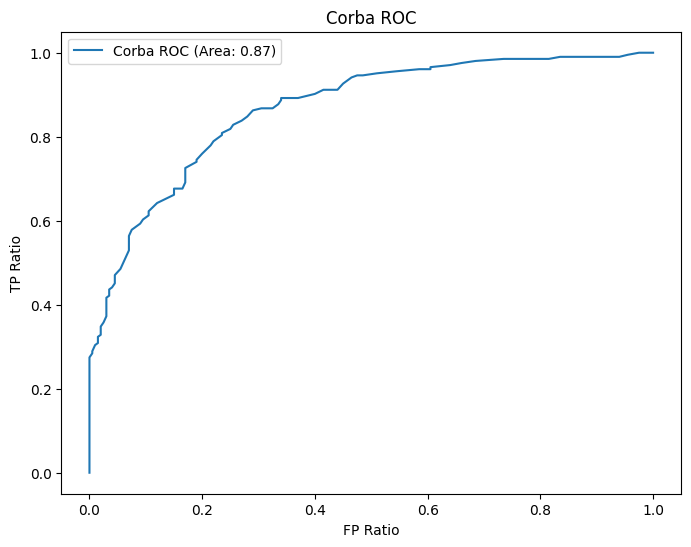

In [169]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_test)[:,1]

'''ROC-AUC'''
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Corba ROC (Area: {roc_auc:.2f})')
plt.xlabel('FP Ratio')
plt.ylabel('TP Ratio')
plt.title('Corba ROC')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

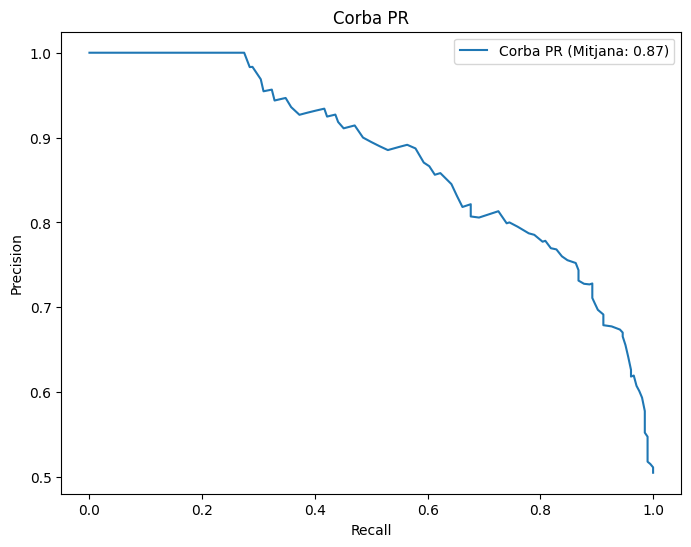

In [170]:
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
mitja_pr = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, label=f'Corba PR (Mitjana: {mitja_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Corba PR')
plt.legend()
plt.show

<section>
<p style="font-family: 'Arial'; font-size:16px;">Amb les corbes ja mostrades, podem veure com la corba ROC-AUC manté una forma bastant uniforme, com és desitjat, amb una àrea AUC de 0.87.</p>

<p style="font-family: 'Arial'; font-size:16px;"> Per altra banda, la corba Precision-Recall sembla també tenir coherència, tot i que visualment no és tant uniforme com la corba ROC-AUC. La mitjana de la precisió es troba en el 0.87, just com l'area de la corba ROC-AUC. </p>

<p style="font-family: 'Arial'; font-size:16px;">Al tenir alguns dubtes amb les mètriques, procedirem a evaluar ambdues mètriques i fer una avaluació dels models amb Cross-Validation.</p>
</section>

# 4. Model Selection | Cross Validation

<section>
<p style="font-family: 'Arial'; font-size:16px;">Un cop hem escollit les mètriques més adients per a l'avaluació del rendiment de la nostra base de dades, continuarem per seleccionar el model d'entrenament que millor resultat ens generi. Farem Cross-Validation per al càlcul del rendiment dels nostres models, on iterarem per cadascún d'ells i guardarem els resultats, finalment escollirem el model amb el rendiment més alt, avaluant tant Accuracy com F1 Score.</p>

<p style="font-family: 'Arial'; font-size:16px;">A continuació, compararem la Regressió Lineal, KNN, Arbre de Decisió i Random Forest, el qual ja ha estat instanciat en l'apartat de selecció de mètriques per visualitzar les corbes ROC-AUC i PR respectivament. No obstant, utilitzarem un altre model de Random Forest per l'entrenament de les dades, ja que abans ja han estat entrenades.</p>

</section>

In [171]:
nouDF=df.copy()
nouDF= nouDF.drop('song_title',axis=1)

rl = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

models = {'Regressio Lineal': rl,
          'KNN': knn,
          'Arbre de Decisio': tree,
          'Random Forest': rf }

resultats = {model: {'Accuracy': [], 'F1 Score': []} for model in models.keys()}  
    
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kfold.split(nouDF):
    X_train, X_test = nouDF.iloc[train_idx].copy(), nouDF.iloc[test_idx].copy()
    X_train, X_test, y_train, y_test = preprocessing_split(X_train, X_test)
    
    for nom_model, model in models.items():
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        resultats[nom_model]['Accuracy'].append(acc)
        resultats[nom_model]['F1 Score'].append(f1)

for nom_model, model in models.items():
    resultats[nom_model]['Accuracy'] = statistics.mean(resultats[nom_model]['Accuracy'])
    resultats[nom_model]['F1 Score'] = statistics.mean(resultats[nom_model]['F1 Score'])

resultats_df = pd.DataFrame(
    [{'Model': model, 'Accuracy': metrics['Accuracy'], 'F1 Score': metrics['F1 Score']} 
     for model, metrics in resultats.items()]
)
resultats_df

,Model,Accuracy,F1 Score
0,Regressio Lineal,0.738244,0.702709
1,KNN,0.735264,0.721974
2,Arbre de Decisio,0.696587,0.688182
3,Random Forest,0.767485,0.744177


<section>
<p style="font-family: 'Arial'; font-size:16px;">A partir dels resultats generats, veiem com el resultat amb millor rendiment és Random Forest. Això creiem que pot ser degut al balanceig de les dades, a partir de la robustesa que suposa davant d'un dataset com el que tenim, en el que no hi ha cap presència d'overfitting ni underfitting degut al gran balanceig de les dades. </p>

<p style="font-family: 'Arial'; font-size:16px;">També ens hem adonat que, amb tots els models, el rendiment millora amb la mètrica Accuracy. Per tant, serà la mètrica escollida per escollir els hiperparàmetres que maximitzen aquest rendiment. </p>

<p style="font-family: 'Arial'; font-size:16px;">Ara que sabem quin es el millor model, buscarem els millors hiperparàmetres per a un Random Forest, és a dir, aquells que maximitzen el seu rendiment, utilitzant GridSearchCV.</p>

</section>

In [172]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['entropy', 'gini'] }
rf = RandomForestClassifier(random_state=42)
#escollim Random Forest com a millor model
grid = GridSearchCV(rf, param_grid, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)

best_params = grid.best_params_
y_pred = model.predict(X_test)

resultats_df = pd.DataFrame(
    [{'Criterion': best_params['criterion'], 'Max_depth': best_params['max_depth'], 'N_estimators': best_params['n_estimators']}])
resultats_df

,Criterion,Max_depth,N_estimators
0,entropy,10,150


<section>
<p style="font-family: 'Arial'; font-size:16px;">Fent ús de la cerca exhaustiva dels hiperparàemtres més òptims ens han resultat per a un Random Forest</p>
<ul>
 <li> Criterion: 'entropy' </li>
 <li> Max_depth: 10 </li>
 <li> N_estimators: 150 </li>

</ul>

<p style="font-family: 'Arial'; font-size:16px;">Partint d'aquests resultats, avaluarem el nostre model amb hiperparàmetres.</p>
</section>

In [173]:
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=150, random_state=42)
resultats = {'Random Forest' :[]}
     
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kfold.split(nouDF):
    X_train, X_test = nouDF.iloc[train_idx].copy(), nouDF.iloc[test_idx].copy()
    X_train, X_test, y_train, y_test = preprocessing_split(X_train, X_test)
    model.fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    resultats['Random Forest'].append(acc)

resultats['Random Forest'] = statistics.mean(resultats['Random Forest'])

resultats=pd.DataFrame(list(resultats.items()), columns=['Model', 'Accuracy'])
resultats

,Model,Accuracy
0,Random Forest,0.765004


<section>
<p style="font-family: 'Arial'; font-size:16px;">Podem observar com, amb els hiperparàmetres seleccionats per GridSearchCV, ens trobem amb un lleuger empitjorament del rendiment, ara sent del 0.7650 contra el 0.7674 d'abans.</p>

<p style="font-family: 'Arial'; font-size:16px;">Això pot ser degut a la complexitat amb la que s'està treballant al tenir tants Arbres de Decisió per l'entrenament del Random Forest, 150 en aquest cas, ja que pot portar a un sobreajustament de les dades d'entrenament.</p>


<p style="font-family: 'Arial'; font-size:16px;"> No obstant, tenim un dataset molt balancejat, pel que la presència d'overfitting o underfitting no ha de ser un problema.</p>

</section>

# 5. Anàlisi Final

<section>
<p style="font-family: 'Arial'; font-size:16px;">Partint de l'explicació de l'apartat anterior, podem constatar que la complexitat del model és un factor important alhora de avaluar el rendiment del nostre Random Forest. Fins ara s'ha parlat de la complexitat pel nombre d'arbres que conformen el model de Random Forest, però la complexitat també pot derivar del nombre d'atributs que ens trobem en el nostre dataset.</p>

<p style="font-family: 'Arial'; font-size:16px;">Hem considerat que, degut a que el nostre model empitjora el rendiment a causa de ser més complex, també pot tenir a veure amb afegir una columna més al nostre dataset, artist_likes, que ens indica el nombre de cops que li ha agradat a l'usuari cançons d'un artista determinat.</p>

<p style="font-family: 'Arial'; font-size:16px;">Per tant, també avaluarem el rendiment del nostre model sense aquest atribut, provant si realment aquest nou atribut afegit és important o no ho és tant realment, analitzant els resultats que ens generi.</p>
</section>

#### SENSE ARTIST_LIKES

In [174]:
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=150, random_state=42)
resultats = {'Random Forest' :[]}
     
    
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kfold.split(nouDF):
    X_train, X_test = nouDF.iloc[train_idx].copy(), nouDF.iloc[test_idx].copy()
    X_train, X_test, y_train, y_test = preprocessing_split(X_train, X_test)

    X_train=X_train.drop('artist_likes',axis=1)
    X_test=X_test.drop('artist_likes',axis=1)
    model.fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    resultats['Random Forest'].append(acc)


resultats['Random Forest'] = statistics.mean(resultats['Random Forest'])

resultats=pd.DataFrame(list(resultats.items()), columns=['Model', 'Accuracy'])
resultats

,Model,Accuracy
0,Random Forest,0.754089


<section>
<p style="font-family: 'Arial'; font-size:16px;">Podem observar com amb l'eliminació de l'atribut artist_likes el accuracy disminueix respecte a tenir artist_likes a la base de dades, de 0.76 a 0.75. Per altra banda, es pot veure que la disminució és molt petita pel que arribem a la conclusió sòlida: l'atribut artist_likes no és tan important com pensàvem.</p>

<p style="font-family: 'Arial'; font-size:16px;">Com s'ha mencionat anteriorment, el limitant del rendiment, per tant, serà la complexitat del nostre model, sigui per implementar molts arbres de decisió al Random Forest o per la creació d'un atribut nou. Això no obstant, ens adonem com, jugant amb les possibilitats que se'ns dona amb els atributs i els hiperparàmetres, és més rellevant aquest nou atribut artist_likes amb una gran correlació amb l'objectiu final target que l'ús dels hiperparàmetres.</p>

<p style="font-family: 'Arial'; font-size:16px;">És interessant tenir en compte això per evitar, per tant, un possible overfitting en utilitzar molts arbres de decisió per al nostre Random Forest, ja que no sempre resulta ser una millora, i tenir en compte també la importància d'entendre el dataset proporcionat i, segons una lògica, pensar en quins podrien ser els atributs que podrien millorar el rendiment del nostre model de classificació.</p>

<p style="font-family: 'Arial'; font-size:16px;">D'aquesta manera el que hem fet ha sigut recuperar la matriu de correlacions del primer apartat. Mitjançant la seva anàlisi, s'ha seleccionat els atributs més rellevants, eliminant-ne aquells amb una correlació molt baixa amb la variable objectiu o amb altes correlacions entre si, ja que podrien estar aportant informació redundant.

</section>

In [175]:
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=150, random_state=42)
resultats = {'Random Forest' :[]}
     
    
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kfold.split(nouDF):
    X_train, X_test = nouDF.iloc[train_idx].copy(), nouDF.iloc[test_idx].copy()
    X_train, X_test, y_train, y_test = preprocessing_split(X_train, X_test)
    
    X_train=X_train[['acousticness', 'danceability', 'duration_ms', 'instrumentalness','loudness', 'speechiness', 'valence','artist_likes']]
    X_test=X_test[['acousticness', 'danceability', 'duration_ms', 'instrumentalness','loudness', 'speechiness', 'valence','artist_likes']]
    model.fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    resultats['Random Forest'].append(acc)


resultats['Random Forest'] = statistics.mean(resultats['Random Forest'])

resultats=pd.DataFrame(list(resultats.items()), columns=['Model', 'Accuracy'])
resultats

,Model,Accuracy
0,Random Forest,0.755595


<section>
<p style="font-family: 'Arial'; font-size:16px;">Sorprenentment, els resultats mostren que l'accuracy obtingut es manté molt semblant respecte a l'aconseguit en utilitzant tots els atributs inicials del dataset, amb només una lleugera disminució insignificant estadísticament. Això posa en evidència que, en molts casos, simplificar el model mitjançant la selecció de característiques pot ser altament beneficiós per reduir la complexitat computacional i evitar problemes com l'overfitting, sense comprometre de manera notable el rendiment.</p>

<p style="font-family: 'Arial'; font-size:16px;">Aquest resultat confirma la importància de la selecció d'atributs en qualsevol projecte de machine learning, ja que permet millorar l'eficiència del model, fent-lo més interpretable i àgil sense sacrificar el seu poder predictiu. A més, aquest enfocament també ens ajuda a entendre millor quines variables són realment crucials per explicar la nostra variable objectiu i a prendre decisions més informades en relació amb la construcció del model.</p>

<p style="font-family: 'Arial'; font-size:16px;">A més, és important destacar que tot i que hi hagi certes modificacions o ajustos que puguin causar una lleugera disminució en alguns aspectes, com l'accuracy o altres mètriques, això no vol dir que aquests canvis no siguin útils. De fet, sovint aquests petits ajustos formen part d'un procés gradual que ens porta a millores més significatives a llarg termini. Cada etapa de l'optimització, encara que sembli reduir una mica el rendiment en algun punt, ens ajuda a aconseguir una millor comprensió del model i, finalment, ens pot permetre assolir un rendiment superior, més sòlid i sostenible.</p>